In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We have structured our report so that for every section, the code to all of our computations and manipulations is contained as functions in the file *utilities.py* .

At every section in the report, we first import the results from the computations from the utilities file and explain how we computed these results.

For the detailed and commented steps taken in our code, you can alwas find the corresponding function in *utilities.py*

# Data Understanding

## 1. Exploratory Data Analysis

- Examination and understanding of the dataset's structure and content.
- Performing exploratory data analysis to understand data patterns, outliers, and relationships between variables.

In [2]:
from utilities import clean_data

In [3]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()

print(df.shape)

(298040, 7)


,period_end_date,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes
0,2017-05-06,24S,NaN,NaN,NaN,NaN,NaN
1,2017-05-13,24S,NaN,6.0,3.0,57.0,1765.0
2,2017-05-20,24S,NaN,6.0,3.0,57.0,1765.0
3,2017-05-27,24S,NaN,6.0,3.0,57.0,1765.0
4,2017-06-03,24S,NaN,24.0,3.0,109.0,3922.0


In [4]:
entries_per_business = df['business_entity_doing_business_as_name'].value_counts()

print(entries_per_business)

Loewe                  455
Michael Kors           455
Muji                   455
Mountain Dew           455
Vacheron Constantin    455
                      ... 
Sculptra               129
Temu                    55
Finding Unicorn         46
Pop Mart                46
ShopGoodwill            26
Name: business_entity_doing_business_as_name, Length: 705, dtype: int64


## 2. Data Cleaning

### Handling Missing Values

In [5]:
from utilities import missing_df, missing_values

In order to get a feeling of the distribution and magnitude of the missing values, we created a new datafram *missing_df* containing the total number of entries per business and the total number of missing values per business per category.

In [6]:
missing_df = missing_df(df)

print(missing_df.shape)

(705, 7)


,Business,Total Entries:,Missing followers:,Missing pictures:,Missing videos:,Missing comments:,Missing likes:
0,24S,333,20,1,1,1,1
1,3.1 Phillip Lim,455,18,0,0,0,0
2,3CE,455,131,0,0,0,0
3,A. Lange & Soehne,403,8,3,2,2,2
4,ANIMALE,403,131,0,2,0,0


We reorganized the DataFrame *df* by date and business, revealing numerous initial missing-value-series across many businesses. By removing these initial series, we reduced the number of rows containing at least one missing value from 65,868 to 4,378.

By identifying the lengths and locations of all remaining missing-value-series in the data, we manage to further decrease the number of rows containing at least one missing value to 4,145. This represents a $ 94 \% $ decrease in rows containing at least one missing value.

In [7]:
cleaned_df = missing_values(df)

Number of rows with at least one NaN before cleaning: 65868
Number of rows with at least one NaN after dropping series of Nan's at beginning of businesses: 4378

 Remaining number of rows with Nan that are not at beginning or end:
Number of rows with 4 NaNs: 3214
Number of rows with 3 NaNs: 0
Number of rows with 2 NaNs: 7
Number of rows with 1 NaNs: 924
Total remaining rows with at least one Nan:  4145

 Total number of rows after cleaning: 236317


Based on the following facts:
- Most of the remaining missing values were are all series of lengths greater than 20, spread randomly through the data.
- There were only 4,145 of the total of 236,317 rows left that contained at least one missing value.

We made the following **assumption**:
- We assumed that the remaining missing values would not affect the performance of our model significantly.

Based on that we decided to leave the remaining missing values for now, and check after implementing the model wether our assumption was correct.

 

### Normalization

In [8]:
from utilities import normalization

The Normalization function is a useful tool when building ML models that work off the number of followers, likes, etc. It Easily scales the Data Frame down by many orders of magnitude.
For example, the number of 'likes' for 'Pepsi' is transformed into its ratio of total likes across all companies, given by the 'likes' from 'All Brands (Study)'

We added it to our utilities since it can be applied in many instances and for easy access

In [9]:
def normalization(df, df_allbrands = clean_data()[2]):
    """ INPUT : Dataframe; df
                Dataframe containing only the sum of the data over all brands; df_allbrands
        OUTPUT : A normalized Dataframe where 'followers', 'pictures'... converted to their share on the total number of 'followers', 'pictures'... """
    #create a new dataframe to make space for the normalized data
    df_normalized = df.copy()
    # Convert the 'period_end_date' column to datetime objects
    df_normalized['period_end_date'] = pd.to_datetime(df_normalized['period_end_date'])

    #Normalization
    #e.g. divide the number of followers for a company by the sum of all followers of all companies
    for date in df_normalized['period_end_date'].unique():
        # Get the indices where the 'period_end_date' matches the current date
        indices = (df_normalized['period_end_date'] == date)
        
        # Normalize each column in df_normalized by the corresponding value in df_allbrands_total
        df_normalized.loc[indices, 'followers'] /= df_allbrands_total.loc[df_allbrands_total['period_end_date'] == date, 'followers'].values[0]
        df_normalized.loc[indices, 'pictures']  /= df_allbrands_total.loc[df_allbrands_total['period_end_date'] == date, 'pictures'].values[0]
        df_normalized.loc[indices, 'videos']    /= df_allbrands_total.loc[df_allbrands_total['period_end_date'] == date, 'videos'].values[0]
        df_normalized.loc[indices, 'comments']  /= df_allbrands_total.loc[df_allbrands_total['period_end_date'] == date, 'comments'].values[0]
        df_normalized.loc[indices, 'likes']     /= df_allbrands_total.loc[df_allbrands_total['period_end_date'] == date, 'likes'].values[0]
        
    return df_normalized

# Modeling Approach

## 1. Feature Engineering

- Feature engineering to create relevant features for identifying deviations.

In [10]:
from utilities import derivatives_data

In [11]:
df_rate, df_curvature = derivatives_data(df)

In the context of wanting to predict outliers and deviations, it is useful to look at time derivatives, gradients etc...
Since the time resolution is fixed at weekly intervals, the derivative of our numerical data will be proportional to simply its difference from one week to the next. From this basic idea we built a function "derivatives_data" which computes two dataframes:
- df_rate_of_change: this contains the first time derivative (slope) of all parameters 'followers', 'likes' ...
- df_curvature     : this contains the second time derivative (curvature) of all parameters 'followers', 'likes' ...

In [12]:
def derivatives_data(df):
    """ INPUT : Dataframe; df
        OUTPUT : Two Dataframes df_rate_of_change, df_curvature that cointain the first and second time derivative of the data respectively """
    """Data Frame df_rate_of_change containing the 1st time derivative in parameters pictures, videos, comments, likes and followers"""
    #create copy for dataframe consisting of 1st derivative
    df_rate_of_change = df.copy()
    parameters = ['followers', 'pictures', 'videos', 'comments', 'likes']
    #I AM NOT YET GOING TO FILL NA'S WITH ZEROS BECAUSE THERE COULD BE OTHERS WHICH WE DONT WANT TO FILL
    #add the first time derivative to each column
    df_rate_of_change['change in followers'] = df_rate_of_change['followers'].diff()
    df_rate_of_change.rename(columns={'pictures': 'change in pictures'}, inplace=True)
    df_rate_of_change.rename(columns={'videos': 'change in videos'}, inplace=True)
    df_rate_of_change.rename(columns={'comments': 'change in comments'}, inplace=True)
    df_rate_of_change.rename(columns={'likes': 'change in likes'}, inplace=True)
    df_rate_of_change.drop(columns=['followers'], inplace=True)

    """Data Frame df_curvature containing the 2nd time derivative in parameters pictures, videos, comments, likes and followers"""
    new_parameters = ['change in followers', 'change in pictures', 'change in videos', 'change in comments', 'change in likes']
    #create copy for dataframe consisting of 2nd derivative
    df_curvature = df_rate_of_change.copy()

    #I AM NOT YET GOING TO FILL NA'S WITH ZEROS BECAUSE THERE COULD BE OTHERS WHICH WE DONT WANT TO FILL
    #add the 2nd time derivative in the parameters to each column
    for i, parameter in enumerate(new_parameters):
        df_curvature[parameter] = df_rate_of_change[parameter].diff()
        df_curvature.rename(columns={ parameter : f'curvature in {parameters[i]}'}, inplace=True)
    
    return df_rate_of_change, df_curvature

Implementing a heatmap to determine which correlations are noteworthy

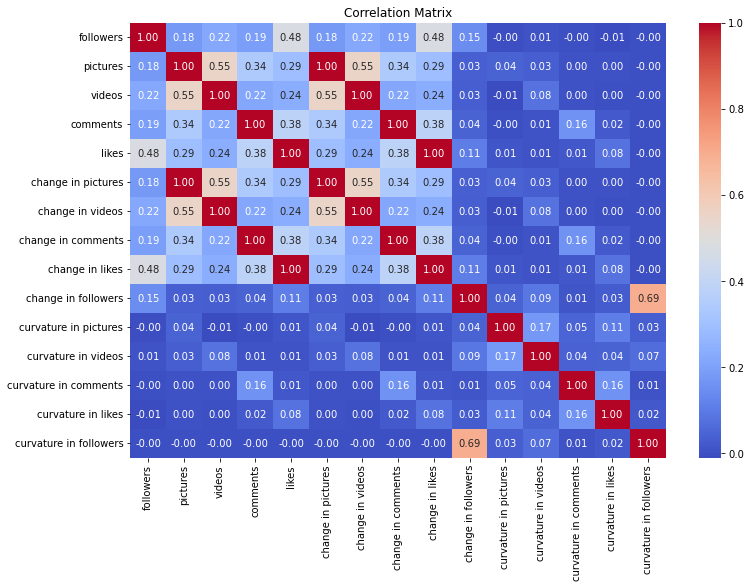

In [13]:
corr_mat = df.corr()
corr_mat_rate = df_rate.corr()
corr_mat_curv = df_curvature.corr()

import seaborn as sns

df_concatenated = pd.concat([df, df_rate, df_curvature], axis=1)

# Compute the correlation matrix
correlation_matrix = df_concatenated.corr()

# Plot the heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We can see a significant correlation in the change of followers and the curvature of the followers data.
In a mathematical sense, if f(t) is the number of followers for a given time t, this correlation somewhat corresponds to the relation
f'(t) ~ f''(t)
where f'(t) and f''(t) denote the first and second time derivative respectively, and ~ is the sign for proportionality.
this differential equation can be solved, revealing the solution for f(t) = f(0)*exp(c*t), where c is a constant.
The correlation coefficient of 0.69 shows tendencies towards exponential growth of follower numbers for the companies in many cases.

## 2. Development of Model

- Development of a model to identify significant deviations from observed trends.

Calculating the Correlation of different variables for different time shifts proved to be of significant help when trying to detect outliers. They Form a Metric for quantifying how much the data within one compset group deviates from the rest

In [14]:
import math
brands_by_cgroup = {} # dict: list of brands contained in each compset_group
for group in compset_groups:
    brands_by_cgroup[group] = df_brands[df_brands['compset_group'] == group][
        'business_entity_doing_business_as_name'].tolist()

cgroup_ranking = {cgroup: df_rate[df_rate['business_entity_doing_business_as_name'].isin(brands_by_cgroup[cgroup])] for cgroup in compset_groups}
compset_groups = df_brands['compset_group'].unique()

#initialize an array to save the correlation values
app_ret_correlation = []
df_corr = pd.DataFrame()
cgroup = 'Outdoor Gear' #in this example we look at companies producing Outdoor gear

for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
    app_ret_correlation = []
    for lag in range(-8, 8):
        app_ret_correlation.append(data['change in likes'].corr(data['change in followers'].shift(lag)))
    
    # Create a temporary DataFrame for the current brand
    df_brand = pd.DataFrame({
        'correlation': app_ret_correlation,
        'lag': np.arange(-8, 8),
        'brand': brand
    })
    
    # Append the data for the current brand to the main DataFrame
    df_corr = pd.concat([df_corr, df_brand], ignore_index=True)

#normalize the curves by dividing by the mean correlation and looking whether the curve deviates significantly by 1
df_corr_normalized = df_corr.copy()
# Calculate the mean correlation for each lag across all companies
mean_corrs = df_corr.groupby('lag')['correlation'].mean()
# Normalize and shift the correlation values for each company
for brand in df_corr_normalized['brand'].unique():
    for lag in df_corr_normalized['lag'].unique():
        # Normalize the correlation values by the mean correlation for the lag across all companies
        df_corr_normalized.loc[(df_corr_normalized['lag'] == lag) & (df_corr_normalized['brand'] == brand), 'correlation'] /= mean_corrs[lag]
    # Shift the correlation values by their own mean to center them around y = 0
    df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'] -= df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'].mean()
    
from scipy.ndimage import gaussian_filter1d

sigma = 2
# Create a copy of the DataFrame for smoothed values
df_corr_smoothed = df_corr_normalized.copy()

# Smooth the correlation values for each brand separately
for brand in df_corr_normalized['brand'].unique():
    # Extract correlation values for the current brand
    brand_data = df_corr_normalized[df_corr_normalized['brand'] == brand]
    # Smooth the correlation values using Gaussian filter
    smoothed_values = gaussian_filter1d(brand_data['correlation'], sigma)
    # Update the DataFrame with the smoothed values
    df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'] = smoothed_values

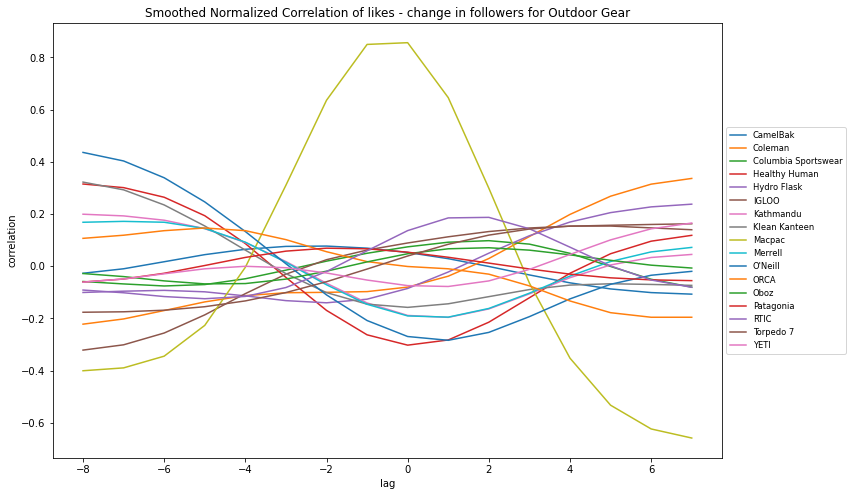

In [15]:
#the comparatevily strong correlation of company macpac around a lag of -1 indicates that for a week with strong likes, their followers increase in week + 1 predictably
plt.figure(figsize=(12,8))
for brand in df_corr_smoothed['brand'].unique():
    plt.plot(range(-8,8), df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'], label = brand)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
plt.title('Smoothed Normalized Correlation of likes - change in followers for Outdoor Gear')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

## 3. Evaluation of Model

- Evaluation of the model's performance and its ability to identify deviations.

# Evaluation of Results

## 1. Analysis of deviations

- Analysis of deviations detected by your model, understanding potential causes.

## 2. Interpretation of the results

- Interpretation of the results, providing strategic insights based on deviations.

## 3. Use of alternative approaches

- Use of alternative approaches (potential enhancement of dataset with external data).